### Continuity


> Samples are needed for sequence models and transformer models for input

😈 **Task 1:** Why might LSTM be more effective for time series than a feedforward model like MLP?

😈 **Question 1:** What types of patterns are LSTM models particularly good at capturing?



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
variable_columns = ["no2", "temp", "o3", "no", "press"]

In [ ]:
import pickle

with open("/content/drive/MyDrive/PatchTOAR/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("/content/drive/MyDrive/PatchTOAR/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("/content/drive/MyDrive/PatchTOAR/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("/content/drive/MyDrive/PatchTOAR/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (561969, 336, 5), y_train shape: (561969, 96, 5)
X_test shape: (140493, 336, 5), y_test shape: (140493, 96, 5)


### Forecasting with Recurrent NN : LSTM

> LSTM multi step ahead and one step ahead predictions

😈 **Task 2:** Compare LSTM results with previous MLP results. What differences do you observe in performance and loss curves?

😈 **Task 3:** Visualize hidden states or prediction errors over time.

In [ ]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'
num_variables = len(variable_columns)
# Reshape as a sanity check
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], len(variable_columns)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_columns)))

#### Multi Step ahead prediction

> Loss accumulation is expected when you do a multi step ahead prediction via LSTM or any sequential model. Due to error propagation, uncertainty growth, data distribution shift. However techniques like scheduled sampling, teacher forcing, and attention mechanisms (as we will illustrate below in transformer architecture) can be used for improvements


😈 **Question 2:** Why does error accumulate in multi-step forecasting?

😈 **Task 4:** Implement scheduled sampling or try a basic attention layer in your LSTM.

In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/file/d/1PgBmn1DpMI0g5PUr1N1J8leB_yK6MDKe/view?usp=sharing
checkpoint_dir = "./checkpoint/lstm_multi_step_checkpoint_96"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_columns):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_columns)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, :, var_idx].reshape(y_train.shape[0], -1)

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(prediction_horizon)
        ])

        lstm_model.compile(optimizer="adam", loss="mse")

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single,
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model

lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)

# scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_columns}
data_raw = pd.read_csv(r"/content/raw_data.csv",
    parse_dates=["datetime"],
)
scaler_stats = {col: {'mean': data_raw[col].mean(), 'std': data_raw[col].std()} for col in variable_columns}

# Evaluate and denormalizing
for var_idx, col in enumerate(variable_columns):
    print(f"Predicting for {col}...")

    X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    lstm_pred_single = lstm_model.predict(X_test_single.reshape(-1, context_window, 1))
    lstm_predictions[:, :, var_idx] = lstm_pred_single

    lstm_predictions[:, :, var_idx] = (
        lstm_predictions[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, :, var_idx] = (
        y_test[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )


Training LSTM for variable 1/5: no2
Loading existing model for variable no2

Training LSTM for variable 2/5: temp
Loading existing model for variable temp

Training LSTM for variable 3/5: o3
Loading existing model for variable o3

Training LSTM for variable 4/5: no
Loading existing model for variable no



Training LSTM for variable 5/5: press
Loading existing model for variable press
Predicting for no2...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for temp...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for o3...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for no...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for press...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step


In [ ]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [ ]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[:, :, var_idx]
    y_pred_single = lstm_predictions[:, :, var_idx]

    print(f"Variable {variable_columns[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable no2:
RMSE: 3.0964
Variable temp:
RMSE: 2.5254
Variable o3:
RMSE: 8.3859
Variable no:
RMSE: 3.2853
Variable press:
RMSE: 3.2015


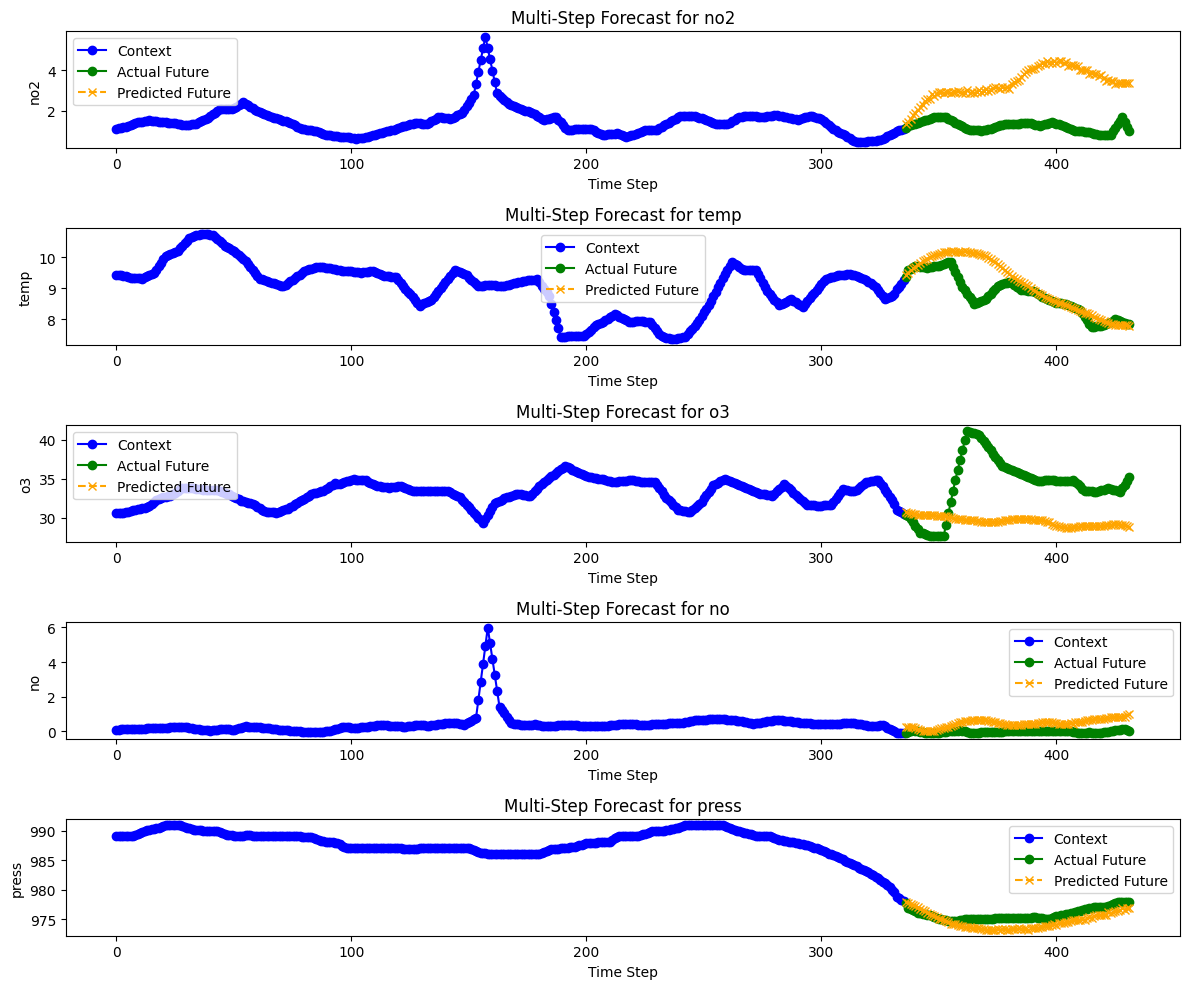

In [ ]:
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_columns):
    plt.subplot(len(variable_columns), 1, var_idx + 1)

    # Extract data for the last sample
    context = X_test[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    actual_future = y_test_actual[-1, :, var_idx] #actual and pred denormalized in prev cell
    predicted_future = lstm_predictions[-1, :, var_idx] #actual and pred denormalized in prev cell

    # Plot context
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    # Plot actual future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        actual_future,
        label="Actual Future",
        color="green",
        marker="o"
    )

    # Plot predicted future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        predicted_future,
        label="Predicted Future",
        color="orange",
        linestyle="--",
        marker="x"
    )

    plt.title(f"Multi-Step Forecast for {col}")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()


#### One Step ahead prediction

😈 **Task 5:** Train both one-step and multi-step models on the same dataset and compare RMSE.

😈 **Question 3:** In what real-world scenario would one-step prediction be more useful than multi-step?


In [ ]:
## checkpoint .zip can be loaded and unarchived from this url
# https://drive.google.com/file/d/11_zb9YCUZRF_CifbrUhY67jyiXXsMbH3/view?usp=sharing
checkpoint_dir = "./checkpoint/lstm_one_step_checkpoints_96"
os.makedirs(checkpoint_dir, exist_ok=True)

training_histories = {}
lstm_models = {}

for var_idx, col in enumerate(variable_columns):
    print(f"\nTraining LSTM for variable {var_idx + 1}/{len(variable_columns)}: {col}")

    X_train_single = X_train_lstm[:, :, var_idx]
    y_train_single = y_train[:, 0, var_idx]

    checkpoint_path = os.path.join(checkpoint_dir, f"lstm_one_step_var{var_idx}.h5")
    ## Ignore user warning on keras as the choice for this exercise is to use h5.

    if os.path.exists(checkpoint_path):
        print(f"Loading existing model for variable {col}")
        lstm_model = load_model(checkpoint_path,custom_objects={"mse": MeanSquaredError()})
    else:
        print(f"Training new model for variable {col}")

        lstm_model = Sequential([
            LSTM(lstm_units, return_sequences=True, input_shape=(context_window, 1)),
            LSTM(lstm_units, return_sequences=False),
            Dense(1)
        ])

        lstm_model.compile(optimizer=lstm_optim, loss=lstm_loss)

        checkpoint_callback = ModelCheckpoint(
            checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
        )

        training = lstm_model.fit(
            X_train_single.reshape(-1, context_window, 1),
            y_train_single.reshape(-1, 1),
            epochs=lstm_epochs, batch_size=lstm_batch_size,
            validation_split=0.2, verbose=1,
            callbacks=[checkpoint_callback]
        )

        training_histories[col] = training.history

    lstm_models[col] = lstm_model
lstm_predictions = np.zeros((y_test.shape[0], len(variable_columns)))
y_test_actual = np.zeros((y_test.shape[0], len(variable_columns)))

# scaler_stats = {col: {'mean': dataframes[col].mean(), 'std': dataframes[col].std()} for col in variable_columns}
data_raw = pd.read_csv(r"/content/raw_data.csv",
    parse_dates=["datetime"],
)
scaler_stats = {col: {'mean': data_raw[col].mean(), 'std': data_raw[col].std()} for col in variable_columns}

# Predict
for var_idx, col in enumerate(variable_columns):
    print(f"Predicting for {col}...")

    X_test_single = X_test_lstm[:, :, var_idx]
    lstm_model = lstm_models[col]

    lstm_pred_single = lstm_model.predict(X_test_single.reshape(-1, context_window, 1)).flatten()
    lstm_predictions[:, var_idx] = lstm_pred_single

    # Inverse transform predictions and actual values
    lstm_predictions[:, var_idx] = (
        lstm_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[:, 0, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )



Training LSTM for variable 1/5: no2
Training new model for variable no2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0139
Epoch 1: val_loss improved from inf to 0.00168, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var0.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 579s 21ms/step - loss: 0.0139 - val_loss: 0.0017
Epoch 2/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043
Epoch 2: val_loss improved from 0.00168 to 0.00147, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var0.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 603s 21ms/step - loss: 0.0043 - val_loss: 0.0015
Epoch 3/5
28097/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0042
Epoch 3: val_loss improved from 0.00147 to 0.00141, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var0.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 612s 22ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 4/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039
Epoch 4: val_loss improved from 0.00141 to 0.00134, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var0.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 594s 21ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 5/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0041
Epoch 5: val_loss did not improve from 0.00134
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 574s 20ms/step - loss: 0.0041 - val_loss: 0.0015

Training LSTM for variable 2/5: temp
Training new model for variable temp
Epoch 1/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052
Epoch 1: val_loss improved from inf to 0.00028, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var1.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 578s 21ms/step - loss: 0.0052 - val_loss: 2.7998e-04
Epoch 2/5
28098/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
Epoch 2: val_loss improved from 0.00028 to 0.00025, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var1.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 609s 22ms/step - loss: 0.0011 - val_loss: 2.5204e-04
Epoch 3/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.9601e-04
Epoch 3: val_loss did not improve from 0.00025
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 611s 22ms/step - loss: 8.9601e-04 - val_loss: 2.6516e-04
Epoch 4/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.1513e-04
Epoch 4: val_loss did not improve from 0.00025
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 610s 22ms/step - loss: 9.1513e-04 - val_loss: 2.7983e-04
Epoch 5/5
28097/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.4323e-04
Epoch 5: val_loss improved from 0.00025 to 0.00023, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var1.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 609s 22ms/step - loss: 9.4323e-04 - val_loss: 2.3246e-04

Training LSTM for variable 3/5: o3
Training new model for variable o3
Epoch 1/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0101
Epoch 1: val_loss improved from inf to 0.01188, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var2.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 611s 22ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 2/5
28098/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033
Epoch 2: val_loss improved from 0.01188 to 0.00110, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var2.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 609s 22ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 3/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
Epoch 3: val_loss did not improve from 0.00110
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 610s 22ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 4/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
Epoch 4: val_loss improved from 0.00110 to 0.00105, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var2.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 610s 22ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030
Epoch 5: val_loss improved from 0.00105 to 0.00098, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var2.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 602s 21ms/step - loss: 0.0030 - val_loss: 9.7772e-04

Training LSTM for variable 4/5: no
Training new model for variable no
Epoch 1/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0602
Epoch 1: val_loss improved from inf to 0.00396, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var3.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 575s 20ms/step - loss: 0.0602 - val_loss: 0.0040
Epoch 2/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0230
Epoch 2: val_loss improved from 0.00396 to 0.00313, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var3.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 573s 20ms/step - loss: 0.0230 - val_loss: 0.0031
Epoch 3/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0191
Epoch 3: val_loss improved from 0.00313 to 0.00254, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var3.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 573s 20ms/step - loss: 0.0191 - val_loss: 0.0025
Epoch 4/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0149
Epoch 4: val_loss improved from 0.00254 to 0.00246, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var3.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 574s 20ms/step - loss: 0.0149 - val_loss: 0.0025
Epoch 5/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0161
Epoch 5: val_loss improved from 0.00246 to 0.00228, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var3.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 575s 20ms/step - loss: 0.0161 - val_loss: 0.0023

Training LSTM for variable 5/5: press
Training new model for variable press
Epoch 1/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033
Epoch 1: val_loss improved from inf to 0.00006, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var4.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 575s 20ms/step - loss: 0.0033 - val_loss: 6.2136e-05
Epoch 2/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.9124e-04
Epoch 2: val_loss did not improve from 0.00006
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 573s 20ms/step - loss: 4.9124e-04 - val_loss: 4.1873e-04
Epoch 3/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.5958e-04
Epoch 3: val_loss did not improve from 0.00006
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 573s 20ms/step - loss: 3.5958e-04 - val_loss: 6.2510e-05
Epoch 4/5
28097/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0774e-04
Epoch 4: val_loss did not improve from 0.00006
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 573s 20ms/step - loss: 4.0774e-04 - val_loss: 6.7863e-05
Epoch 5/5
28099/28099 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1481e-04
Epoch 5: val_loss improved from 0.00006 to 0.00006, saving model to ./checkpoint/lstm_one_step_checkpoints_96/lstm_one_step_var4.h5


28099/28099 ━━━━━━━━━━━━━━━━━━━━ 573s 20ms/step - loss: 4.1481e-04 - val_loss: 5.9615e-05
Predicting for no2...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for temp...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for o3...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for no...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step
Predicting for press...
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step


In [ ]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[ :, var_idx]
    y_pred_single = lstm_predictions[ :, var_idx]

    print(f"Variable {variable_columns[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable no2:
RMSE: 0.2015
Variable temp:
RMSE: 0.1177
Variable o3:
RMSE: 0.4277
Variable no:
RMSE: 0.2769
Variable press:
RMSE: 0.1040


In [ ]:
lstm_rolling_predictions = np.zeros((prediction_horizon, len(variable_columns)))
y_test_actual = np.zeros((prediction_horizon, len(variable_columns)))

# Select the last sample from the test set
X_test_single = X_test_lstm[-1]

for var_idx, col in enumerate(variable_columns):
    X_test_var = X_test_single[:, var_idx].reshape(1, context_window, 1)

    for step in range(prediction_horizon):
        lstm_pred_single = lstm_models[col].predict(X_test_var)

        lstm_rolling_predictions[step, var_idx] = lstm_pred_single[0, 0]

        # Shift the window and append the new prediction
        X_test_var = np.roll(X_test_var, shift=-1, axis=1)
        X_test_var[0, -1, 0] = lstm_pred_single

    # Inverse scale the predictions and actual values for the current variable
    lstm_rolling_predictions[:, var_idx] = (
        lstm_rolling_predictions[:, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )
    y_test_actual[:, var_idx] = (
        y_test[-1, :prediction_horizon, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<ipython-input-15-21fcf0c17e56>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_test_var[0, -1, 0] = lstm_pred_single


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

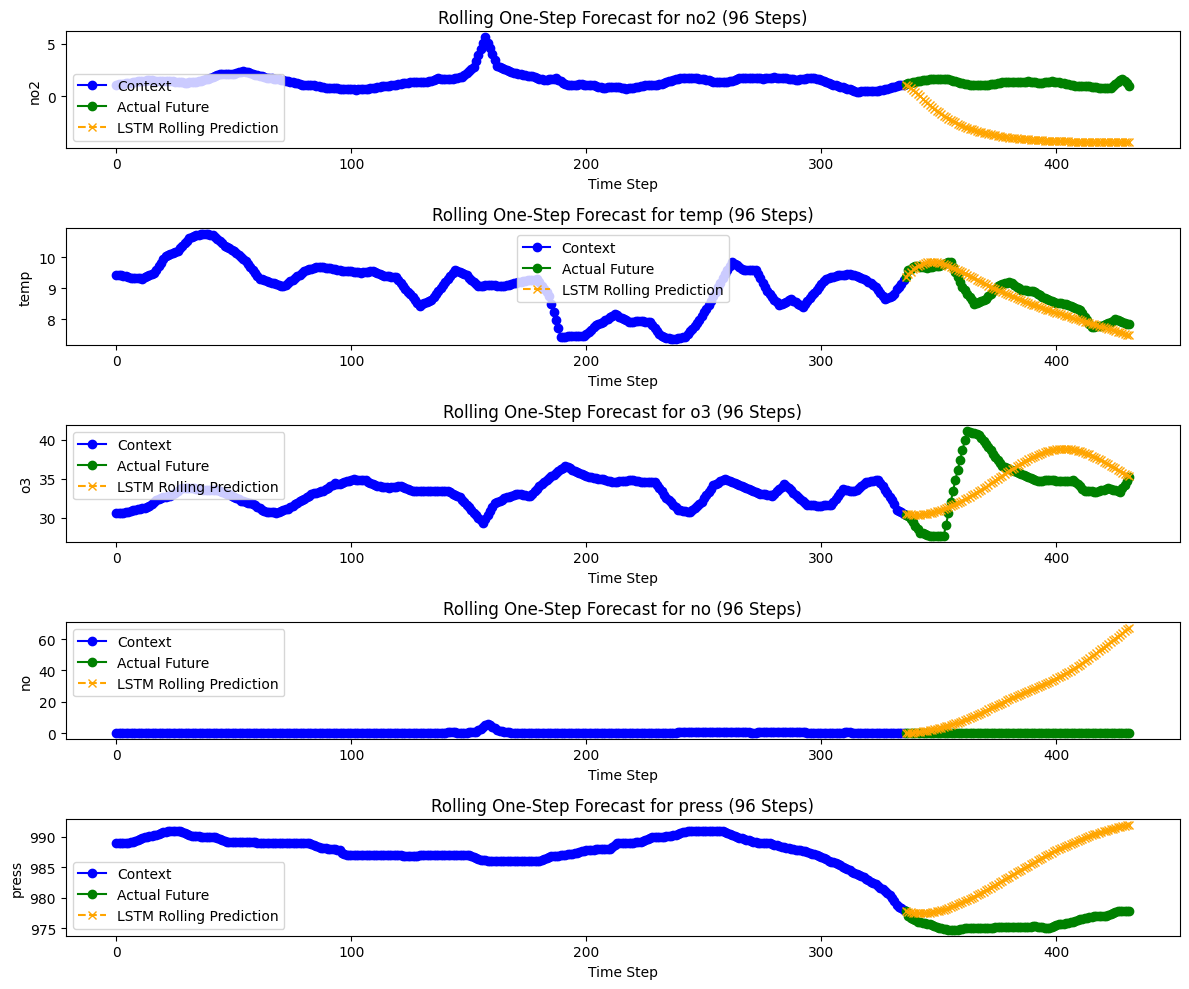

In [ ]:
# Plot Rolling One-Step-Ahead Forecast for All Variables (for the last sample)
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_columns):
    plt.subplot(len(variable_columns), 1, var_idx + 1)

    context = X_test_lstm[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    actual_future = y_test_actual[:, var_idx] #actual and pred denormalized in prev cell
    predicted_future = lstm_rolling_predictions[:, var_idx] #actual and pred denormalized in prev cell

    # Plot context window
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), actual_future,
             label="Actual Future", color="green", marker="o")

    plt.plot(range(context_window, context_window + prediction_horizon), predicted_future,
             label="LSTM Rolling Prediction", color="orange", linestyle="--", marker="x")

    plt.title(f"Rolling One-Step Forecast for {col} ({prediction_horizon} Steps)")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()